In [1]:
# Imports

from OverwatchProcessData import get_vector_herostats
from OverwatchProcessData import get_competitive_rank, hero_stats
from OverwatchGatherData import Player, find_usernames

import numpy as np
import os

np.random.seed(3)

from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Loading Data

HERO = 'mercy'

specific_stats = []

for stat in hero_stats:
    
    if stat.startswith(HERO):
        
        specific_stats.append(stat)

def generate_players():
    
    for filename in os.listdir('profiles'):
        
        player = Player.from_file(os.path.join('profiles', filename))
        
        if 'error' not in player.json:
            
            yield player

def load_data():

    unscaled_X, unscaled_y = [], []

    for player in generate_players():

        rank = get_competitive_rank(player, 'us')

        if rank:
            
            try:
                
                time_played = player.json['us']['heroes']['stats']['competitive'][HERO]['general_stats']['time_played']
                
                if time_played > 0:
                
                    unscaled_X.append(get_vector_herostats(player, 'us', stat_keys=specific_stats))
                    unscaled_y.append(rank)
                
            except:
                
                pass
           

    unscaled_X = np.array(unscaled_X, dtype=np.float64)
    unscaled_y = np.array(unscaled_y, dtype=np.float64)
    
    print(unscaled_X.shape)
    print(unscaled_y.shape)
    
    return unscaled_X, unscaled_y

len(specific_stats)

145

In [3]:
# Scale

def scale_data(unscaled_X, unscaled_y):
    
    scaler_X = StandardScaler()

    X = scaler_X.fit_transform(unscaled_X)
    y = unscaled_y / 5000
    
    return X, y, scaler_X


In [4]:
# Model

def get_model():
    
    model = Sequential()
    model.add(Dense(20, input_dim=len(specific_stats), kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(20, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(20, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(20, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(20, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(20, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(20, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model


In [5]:
# Train wrapper

def train_model(model, *args, **kwargs):
    
    print(model.summary())

    history = model.fit(*args, **kwargs, shuffle=True, verbose=0)
    
    return history


In [6]:
# Predict

def predict_sr(model, player, scaler_for_X):
    
    stats_vector = np.array([get_vector_herostats(player, 'us', stat_keys=specific_stats)])
    
    X = scaler_for_X.transform(stats_vector)

    y_matrix = model.predict(X)
    
    sr = np.squeeze(y_matrix) * 5000
    
    return int(sr)


In [7]:
# View

def view(history):
    
    plt.plot(np.log(history.history['loss']))
    plt.plot(np.log(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('Log(loss)')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    
    plt.plot(np.sqrt(history.history['loss']) * 5000)
    plt.plot(np.sqrt(history.history['val_loss']) * 5000)
    plt.title('Model Accuracy')
    plt.ylabel('Avg Accuracy')
    plt.xlabel('epoch')
    plt.ylim([0, 1250])
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()


(10355, 145)
(10355,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                2920      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)               

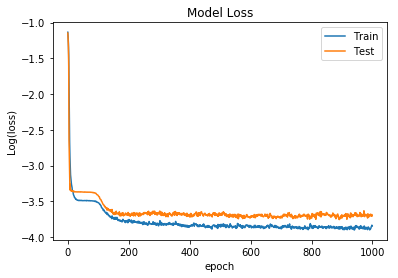

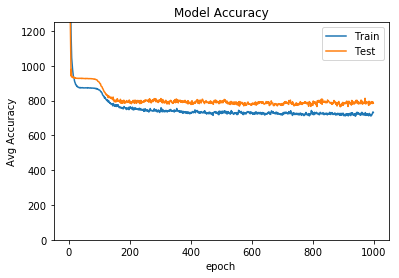

In [8]:
# Run

X, y, scaler_X = scale_data(*load_data())

model = get_model()

history = train_model(model, X, y, epochs=1000, batch_size=1024, validation_split=.10)

model.save(os.path.join('models', '{}-sr.h5'.format(HERO)))

view(history)


In [ ]:

with open('test_names.txt', 'r') as test:

    for battletag in find_usernames(test.read()):
        
        player = Player.from_web_battletag(battletag)
        
        actual = get_competitive_rank(player, 'us')
        p = predict_sr(model, player, scaler_X)
        
        print("{} is {}, predicted {}".format(battletag, actual, p))
